Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolas Guarín-Zapata 2019. Este material es parte del curso Mecánica de los Medios Continuos en el programa de Ingeniería Civil de la Universidad EAFIT.

# Creación del modelo de SolidsPy

## Introducción

Este notebook describe el proceso de creación de un modelo para análisis por elementos finitos con `SolidsPy`. El ejemplo cubre la creación de la geometría y la malla del modelo en el programa `Gmsh` y su posterior conversión a archivos de texto listos para ser procesados por `SolidsPy`. Este último paso se realiza con usando funciones de la biblioteca `meshio`.

**Al completar este notebook usted debería estar en la capacidad de:**

* Identificar la representación de un modelo por elementos finitos en el código abierto `SolidsPy` en términos de archivos de texto plano.

* Usar `Gmsh` para crear modelos por elementos finitos de dominios bidimensionales listos para ser procesados por `SolidsPy`.

* Escribir los _scripts_ de Python que se requieran para convertir un modelo de `Gmsh` a uno de `SolidsPy`.

**Nota:** Para poder ejecutar este notebook es necesario tener instalados SolidsPy y las bibliotecas requeridas (ver documentación del programa en [SolidsPy](https://solidspy.readthedocs.io/en/latest/readme.html)).

## SolidsPy

`SolidsPy` es un programa para la realización de análisis de tensiones de dominios con geometrías planas de formas arbitrarias y con materiales elásticos lineales. El programa ha sido creado por Juan Gomez y Nicolas Guarin-Zapata del laboratorio de Mecánica Aplicada de la [Universidad EAFIT](http://www.eafit.edu.co/) para ser usado con propósitos de docencia en las diferentes materias del área de Mecánica Computacional del programa de Ingeniería Civil.

Por defecto `SolidsPy` soporta los siguientes tipos de elementos:

<center><img src="img/elelib.png" alt="files" style="width:600px"></center>


Un modelo de elementos finitos en `SolidsPy` se representa en términos de archivos de texto plano que definen los nodos, elementos, cargas y propiedades de los materiales. El programa se encuentra documentado en [SolidsPy](https://solidspy.readthedocs.io/en/latest/readme.html).

## Pasos en la creación de un modelo por elementos finitos en SolidsPy

`SolidsPy` permite realizar análisis de tensiones sobre dominios bidimensionales (bajo condiciones de esfuerzo plano) discretizados mediante elementos finitos. El programa usa como datos de entrada, una representación de elementos finitos del sólido, dada en términos de archivos de texto plano en los cuales se define la:

* Información de los nudos: Coordenadas espaciales y condiciones de frontera para cada nudo del elemento.

* Información de los elementos: Esquema fundamental de interpolación, tipo de material asociado y nudos que definen cada elemento.

* Información de cargas: Vector de cargas (definidas en un sistema de referencia cartesiano) e información para cada nodo cargado en el modelo.

* Información de los materiales: Módulo de elasticidad y relación de Poisson para cada tipo de material que se use en el modelo.

La creación de un modelo en `SolidsPy` implica 2 pasos básicos correspondientes a:

1. Mallado del dominio del problema.

2. Escritura de archivos de texto conteniendo la malla y la información adicional correspondiente a cargas, materiales y restricciones de desplazamientos.

En el caso de dominios con geometrías complejas que impliquen un gran número de elementos el paso **1** se ejecuta con la ayuda de paquetes externos. Acá usaremos  [Gmsh](http://gmsh.info/) para crear mallas de elementos finitos.

Si la malla se crea en un paquete externo como `Gmsh`  será necesario reescribir los archivos resultantes del paquete externo en forma de los archivos de texto que puedan ser interpretados por `SolidsPy`. Para esto usaremos subrutinas que han sido creadas usando [meshio](https://github.com/nschloe/meshio). El proceso completo se esquematiza en la siguiente figura.

<center><img src="img/steps.png" alt="files" style="width:700px"></center>

## Definición del problema

El problema a resolver consiste en determinar el tensor de tensiones sobre una placa fabricada de 2 materiales (asumiendo condiciones de deformación plana) y con una carga uniformemente distribuida de intensidad $W$ aplicada sobre la cara superior (ver figura).

<center>
    <img src="img/biplate.png"
         alt="Placa bimaterial"
         style="width:500px">
</center>

Cada material se caracteriza por su relación de Poisson y su modulo de Elasticidad. La cara inferior esta restringida a desplazamientos verticales, mientras que las caras laterales no se pueden desplazar horizontalmente. Estas condiciones se esquematizan mediante los apoyos de rodillos.

## Creación del modelo

En este notebook solo se cubrirá el paso **2** correspondiente a la re-escritura de los archivos de texto asumiendo que el modelo de `Gmsh` ya ha sido creado y que la malla se encuentra disponible para ser procesada. El video adjunto muestra los pasos para la creación del modelo en `Gmsh`.  

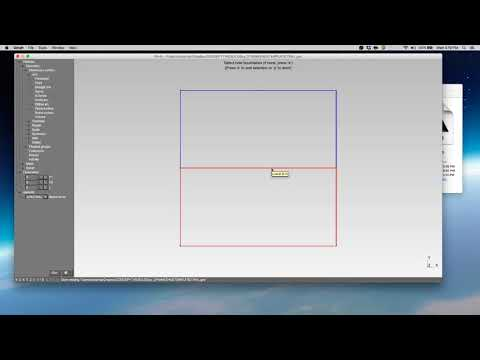

In [113]:
from IPython.display import YouTubeVideo
YouTubeVideo('ibeIKaSYG2U', width=600, height=450)

En `Gmsh` un modelo se define mediante la combinación de **objetos geométricos** de diferente jerarquía. En el caso de dominios planos estos se resumen en:

* Puntos.
* Lineas: Formadas por la unión de puntos.
* Superficies planas (o circuitos de lineas): Formadas mediante la combinación de varias líneas.

El proceso se ilustra en la siguiente figura. Nótese que las lineas se encuentran orientadas en la dirección indicada por la flecha en cada caso. Similarmente, las superficies planas se encuentran orientadas. En el caso del ejemplo la orientación de las superficies es en sentido anti-horario. Es necesario respetar esta orientación ya que la misma se asume en la codificación de los elementos en `SolidsPy`.

<center><img src="img/geometric.png" alt="files" style="width:600px"></center>

<div class="alert alert-warning">
    
La definición de un modelo por elementos finitos en `Gmsh` implica 2 pasos:

1. La definición de la geometría del dominio, la cual queda almacenada en un archivo de extensión `.geo`.

2. El mallado o partición de la geometría del dominio en elementos finitos definidos por nudos. Esta información queda almacenada en un archivo con extensión `.msh`. 

</div>

El software de mallado, en este caso `Gmsh`, solamente divide el dominio de computación en elementos finitos definidos por puntos (o nodos). Por lo tanto el modelo resultante aún no tiene información relativa a las condiciones de frontera o a los materiales de los diferentes elementos y esta información tiene que definirse mediante operaciones posteriores.

Para facilitar estas operaciones sobre las diferentes partes del modelo requeridas para el análisis por elementos finitos `Gmsh` permite la definición de grupos o conjuntos de **objetos geométricos** a los cuales denomina como **objetos físicos**. En otras palabras, un **objeto físico** no es otra cosa que un conjunto especial de **objetos geométricos**.

Los **objetos físicos** son útiles a la hora de definir las cargas aplicadas sobre lineas especificas del modelo, o de asignar propiedades de material a las diferentes partes del dominio como también en la definición de las restricciones del desplazamiento sobre grupos específicos de nodos.

La figura presenta los **objetos físicos** para el ejemplo.

<center>
    <img src="img/phys_OBJ.png" alt="files" style="width:600px">
</center>

Nótese que cada grupo de **objetos físico** es nombrado mediante un numéro entero. La linea física **500**  define la cara superior del modelo en la cual se aplicará la carga uniforme; la linea física **300** agrupa las caras laterales donde se restrinigirá la componente horizontal del desplazamiento; la linea física **400** define la cara inferior sobre la que se restringirán los desplazamientos verticales. De manera similar, las superficies físicas **100** y **200** definen las regiones del modelo sobre las cuales se asignarán propiedades de material 1 y 2 respectivamente.

<div class="alert alert-warning">
Las definciones de los objetos físicos se realizan directamente durante la generación del modelo geométrico en gmsh. Estas quedan declaradas en el archivo con extensión .geo. Posteriormente, y una vez creada la malla, gmsh asigna esta información a los nudos y elementos que perenezcan a los objetos físicos previamente definidos.    
</div>

## Re-escritura de los archivos de Gmsh a archivos de texto para SolidsPy

Una vez creada la malla, la información de nudos, lineas, elementos y otras entidades geométricas serán asociadas a los diferentes **objetos físicos** para facilitar su interpretación por medio de subrutinas externas. En `SolidsPy` un modelo de elementos finitos se define en términos de 4 archivos de texto: `nodes.txt`, `eles.txt`, `loads.txt`y `mater.txt`. la creación de estos archivos a partir del modelo de `Gmsh` se esquematiza en la figura.

**Nota:** La estructura de los archivos de entrada usados por SolidsPy se describe para el caso de un problema simple de un  [cuadrado](https://solidspy.readthedocs.io/en/latest/tutorials/square_example.html) conformado por 4 elementos finitos.

<center><img src="img/conversion.png" alt="files" style="width:700px"></center>

Para realizar la conversión de Gmsh a SolidsPy es necesario escribir un script para cada problema. El script se basa en subrutinas disponibles en el modulo de pre-procesado de SolidsPy. Estas rutinas interpretan el modelo de Gmsh utilizando los nombres asignados para los diferentes **objetos físicos.** Las rutinas se resumen en:

* `node_writer`: Esta función regresa un arreglo llamado `nodes_array` listo para ser escrito en el archivo de nudos `nodes.txt` de SolidsPy.

* `oundary_conditions`: Manipula cada linea física donde se impondrán condiciones de frontera.

* `loading`: Esta subrutina usa las magnitudes de las cargas a lo largo de las direcciones $x$ y $y$ definidas por los parámetros $P_x$ y $P_y$ y divide la fuerza resultante por el número de nodos que pertenecen a la **línea física**.

* `ele_writer`: Esta se usa para escribir los archivos de texto con la información de los elementos. La subrutina debe ser usada tantas veces como superficies físicas tenga el modelo para asignar los tipos de material correspondientes a los elementos sobre la superficie.

El siguiente bloque de código importa los modulos necesarios. En particular note que se importan los modulos de preprocesado y el modulo externo meshio sobre el cual se escriben las subrutinas del pre-procesador.

In [114]:
import numpy as np  
import matplotlib.pyplot as plt
import meshio
import solidspy.preprocesor as msh

In [115]:
%matplotlib notebook

El siguiente bloque lee la malla y la convierte en el objeto **mesh.** Posteriormente, en las 4 lineas que le siguen se forman los diccionarios points, cells, point_data, cell_data y field_data.

In [116]:
mesh = meshio.read("files/placa.msh")
points = mesh.points
cells = mesh.cells
point_data = mesh.point_data
cell_data = mesh.cell_data
field_data = mesh.field_data

<div class="alert alert-warning">
Imprima los diccionarios `points`, `cells` y `cell_data` e identifique los nombres asignados a los grupos físicos.
</div>

En la linea que sigue se usa la rutina `node_writer()` para extraer del diccionario points la información nodal y almacenarla en el arreglo de numpy `nodes_array`.

In [117]:
nodes_array = msh.node_writer(points, point_data)

La rutina de procesado de elementos `ele_writer()` tiene como parametros de entrada los diccionarios cells y cell_data para escribir los arreglos de elementos. En esta llamada se indica que los elementos corresponden a triangulos lineales tal y como lo indica la palabra clave de **gmsh** `triangle`. Estos elementos pertencen a la superficie física identificada por el nombre $100$. El entero $3$ en este caso es el indice de tipo de elemento de acuerdo a la nomenclatura de **SolidsPy**. El penultimo campo correspondiente a $0$ indica que esta superficie tendrá asignado el perfil de material $0$. Finalmente el parametro entero $0$ es el primer numero de elemento para esta superficie en el archivo de **SolidsPy**. La rutina entrega tras su ejecución un arreglo de numpy, en este caso, almacenando la información de los elementos de la superficie física $100$. Adicioanalmente entrega el numéro de elementos asignados a esta superficie. Este parametro se usa para inciar el conteo de elementos en la siguiente superficie.

In [118]:
nf, els1_array = msh.ele_writer(cells, cell_data, "triangle", 100, 3, 0, 0)

La siguiente superfice de elementos a procesar corresponde a la identificada como superficie física $200$, también de elementos triangulares, con perfil de material tipo $1$ e iniciando el conteo de acuerdo con el valor inicial nini = nfin, donde nfin es el valor arrojado por la última superficie procesada.

In [119]:
nini = nf
nf, els2_array = msh.ele_writer(cells, cell_data, "triangle", 200, 3, 1, nini)

Una vez generados los 2 arreglos de elementos correspondientes a las superficies $100$ y $200$ estos deben ser concatenados en uno solo arreglo `els_array`  para posteriormente imprimirlos en el archivo de texto.

In [120]:
els_array = np.append(els1_array, els2_array, axis=0)

El siguiente punto en la creación del modelo se imponen las restricciones de desplazamiento sobre las caras $300$ (caras laterales) y $400$ cara del fondo. La función `boundary_conditions()` impone estas condiciones aplicando valores de $-1$ a los nudos de las lineas que representan estas caras sobre los grados de libertad correspondientes.

In [121]:
nodes_array = msh.boundary_conditions(cells, cell_data, 300, nodes_array, -1, 0)
nodes_array = msh.boundary_conditions(cells, cell_data, 400, nodes_array, 0, -1)

Finalmente la rutina `loading()` identifica los nudos sobre la linea física $500$ e impone la carga $W = -2.0$. Esta es distribuida entre todos los nudos de la linea de manera que su resultante se mantiene constante.

In [122]:
cargas = msh.loading(cells, cell_data, 500, 0.0, -2.0)

In [123]:
np.savetxt("files/Meles.txt" , els_array, fmt="%d")
np.savetxt("files/Mloads.txt", cargas, fmt=("%d", "%.6f", "%.6f"))
np.savetxt("files/Mnodes.txt", nodes_array , fmt=("%d", "%.4f", "%.4f", "%d", "%d"))

La figura hace una descripción gráfica de las rutina de generación de los archivos de entrada para SolidsPy.


<center>
    <img src="img/grafdescr.png"
         alt="files"
         style="width:700px">
</center>

In [124]:
def readin():
    nodes    = np.loadtxt('files/Mnodes.txt', ndmin=2)
    mats     = np.loadtxt('files/Mmater.txt', ndmin=2)
    elements = np.loadtxt('files/Meles.txt', ndmin=2, dtype=np.int)
    loads    = np.loadtxt('files/Mloads.txt', ndmin=2)
    return nodes, mats, elements, loads

In [125]:
nodes, mats, elements, loads = readin()

<div class="alert alert-warning">
    
* Verifique que los archivos de texto han sido creados en la carpeta files.
    
* Imprima los arreglos de nudos, elementos y cargas e identifique su estructura.
</div>

### Glosario de términos

**Gmsh:** Mallador libre por elementos finitos para dominios planos y tridimensionales.

**Objetos geométricos:** Entidades geomeéricas organizadas de manera jerárquica (puntos, lineas, superficies) usadas en la construcción de dominios computacionales en Gmsh.

**Objetos físicos:** Grupos específicos de objetos definidos dentro de Gmsh y usados para facilitar posteriores operaciones requeridas en la creación de un modelo por elementos finitos.

**meshio:** Biblioteca de Python desarrollada por [Nico Schlomer](https://github.com/nschloe) y disponibles en [meshio](https://github.com/nschloe/meshio), útil para ejecutar operaciones de lectura/escritura entre varios formatos de mallas inlcuyendo Gmsh.

**Script de mallado:** Script de Python desarrolada para cada modelo y usada para "traducir" modelos de Gmsh a modelos de SolidsPy. Para escribir el script se usan funciones de meshio.

## Referencias

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

* Nico Schlömer, Geordie McBain, Tianyi Li, Vicente Mataix Ferrándiz, eolianoe, Lisandro Dalcin, … Abhinav Gupta. (2019, May 10). nschloe/meshio: 2.3.7 (Version v2.3.7). Zenodo <https://github.com/nschloe/meshio>

* C. Geuzaine and J.-F. Remacle. Gmsh: a three-dimensional finite element mesh generator with built-in pre- and post-processing facilities. International Journal for Numerical Methods in Engineering 79(11), pp. 1309-1331, 2009.

## Formato del notebook

La siguiente celda cambia el formato del Notebook.

In [126]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()